In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from astroML import stats as astroMLstats
from sklearn.neighbors import KernelDensity

In [2]:
#function that computes the irreducible mass starting by BH's mass and spin

def irreducible_mass(M,chi):
    return M*((1+(1-chi**2)**0.5)/2)**0.5


#function to compute the pdf using KDE
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

#functions to compute the theoretical pdf using Montecarlo integration

def integrand(f,M_irr,mu,sigma):
    return(((2/np.pi**0.5)/sigma)*np.exp(-((M_irr/f)-mu)**2/(2*sigma**2))*(2*f**2-1)/(f*(1-f**2)**0.5))

#I'm using Montecarlo integration by a uniform density distribution. I could have used 
#the distributution of f but it would require a renormalization in the considered interval

def montecarlo_integral_uniform(n,M_irr,mu,sigma):
    f=np.random.uniform(1/(2)**0.5,1,size=n)
    y=integrand(f,M_irr,mu,sigma)
    return((1-1/2**0.5)*np.mean(y))

Text(0.5, 0, 'Irreducible mass')

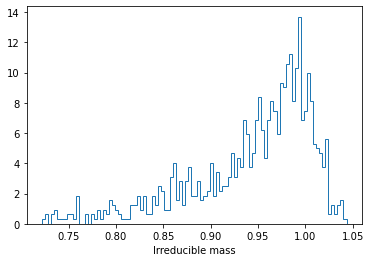

In [3]:
#sampling chis and masses

#spin from a uniform distribution
chi=np.random.uniform(0,1,1000)

#mass from a gaussian distribution
mass=np.random.normal(1,0.02,1000)

#computing the irreducible mass

irr_mass=irreducible_mass(mass,chi)

#plotting 

plt.hist(irr_mass,bins=100,density=True,histtype='step');
plt.xlabel('Irreducible mass')


binsize using Scott's rule 0.01508104283022319
binsize using Friedmann-Diaconis rule 0.03357928716587455


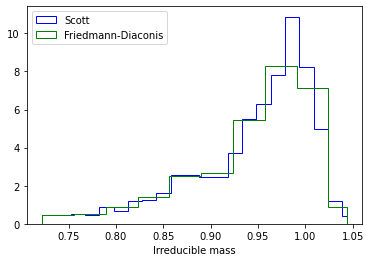

In [4]:
#computing the bin size by Scott's rule 

dim_s=3.5*0.02/(100)**(1/3)

#computing bin size by Freedmann-Diaconis' rule

sigmaG2 = astroMLstats.sigmaG(irr_mass)
dim_FD=2.7*sigmaG2/(100)**(1/3)

print("binsize using Scott's rule",dim_s)
print("binsize using Friedmann-Diaconis rule",dim_FD)

#building histograms

binsG1 = np.append(np.arange(start=irr_mass.min(), stop=irr_mass.max(), step=dim_s),irr_mass.max())
binsG2 = np.append(np.arange(start=irr_mass.min(), stop=irr_mass.max(), step=dim_FD),irr_mass.max())

#plotting

plt.hist(irr_mass,bins=binsG1,density=True,histtype="step",color='blue',label='Scott');
plt.hist(irr_mass,bins=binsG2,density=True,histtype="step",color='green',label='Friedmann-Diaconis');
plt.xlabel('Irreducible mass')
plt.legend(loc='upper left')
plt.show()

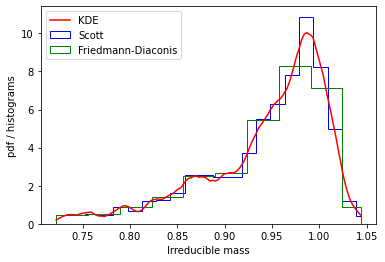

In [5]:
#computing the KDE pdf

xgrid = np.linspace(np.min(irr_mass),np.max(irr_mass),1000)  
y=kde_sklearn(irr_mass,0.015)

#plotting

plt.hist(irr_mass,bins=binsG1,density=True,histtype="step",color='blue',label='Scott');
plt.hist(irr_mass,bins=binsG2,density=True,histtype="step",color='green',label='Friedmann-Diaconis');
plt.plot(xgrid,y,color='red',label='KDE')
plt.legend(loc='upper left')
plt.xlabel('Irreducible mass')
plt.ylabel('pdf / histograms')
plt.show()

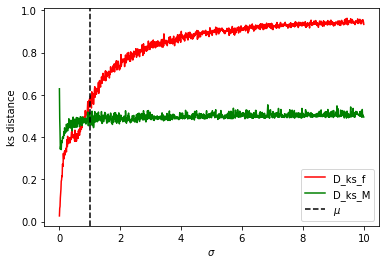

In [10]:
#defining sigmas to use

sigmas=np.linspace(0.01,10,1000)

#sampling spins and masses and computing the irreducible mass

chi=np.array([np.random.uniform(0,1,1000) for i in range(0,len(sigmas))])
M=np.array([np.random.normal(1,sigma,1000) for sigma in sigmas])
M_irreducible=irreducible_mass(mass,chi)
fs=M_irreducible/M

#computing the ks distances for different sigmas

D_ks_f=np.array([scipy.stats.kstest(M_irr,f)[0]for M_irr,f in zip(M_irreducible,fs)])
D_ks_M=np.array([scipy.stats.kstest(M_irr,mass)[0]for M_irr,mass in zip(M_irreducible,M)])

#plotting

plt.plot(sigmas,D_ks_f,c='red',label='D_ks_f')
plt.plot(sigmas,D_ks_M,c='green',label='D_ks_M')
plt.axvline(x=1,color='black',linestyle='--',label='$\mu$')
plt.xlabel(r'$\sigma$')
plt.ylabel('ks distance')
plt.legend()
plt.show()


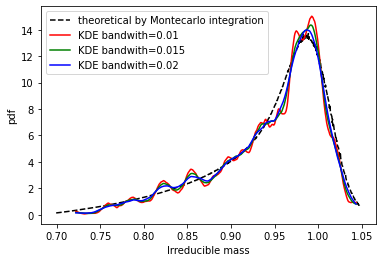

In [9]:
#computing the theoretical pdf by Montecarlo integration:

N=1000
M_irr=np.linspace(np.min(irr_mass),np.max(irr_mass),N)
p=np.array([montecarlo_integral_uniform(500000,M,1,0.02) for M in M_irr])

#sampling and computing the pdf by KDE using different bandwidths:

chi=np.random.uniform(0,1,1000)
mass=np.random.normal(1,0.02,1000)
irr_mass=irreducible_mass(mass,chi)

y1=kde_sklearn(irr_mass,0.01)
y2=kde_sklearn(irr_mass,0.015)
y3=kde_sklearn(irr_mass,0.02)

#normalizing and plotting:

x_grid=np.linspace(np.min(irr_mass),np.max(irr_mass),N)
scale=np.max(y)/np.max(p)

plt.plot(x_grid,p*M_irr,linestyle='--',color='black',label='theoretical by Montecarlo integration')
plt.plot(xgrid,y1/scale,color='red',label='KDE bandwith=0.01')
plt.plot(xgrid,y2/scale,color='green',label='KDE bandwith=0.015')
plt.plot(xgrid,y3/scale,color='blue',label='KDE bandwith=0.02')

plt.xlabel('Irreducible mass')
plt.ylabel('pdf')

plt.legend(loc='upper left')

plt.show()